In [1]:
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as np
import pyforfluids as pff
import matplotlib.pyplot as plt
float64 = "float64"

In [2]:
kij = np.array([
    [0, 0],
    [0, 0],
], dtype=float64)

lij = 0 * 1.5*kij

z = np.array([0.3, 0.7], dtype=float64)
p = 2.0
v = 100.0
t = 150.0

tc = np.array([190, 304], dtype=float64)
pc = np.array([45, 74], dtype=float64)
w = np.array([0.19, 0.1], dtype=float64)

penerob = pff.models.cubic.PR76(tc, pc, w)
mixrule = pff.models.mixingrules.ClassicVdW(kij, lij)
armodel = pff.models.cubic.CubicEoS(penerob, mixrule)

system = pff.models.system.System(armodel, None, None)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


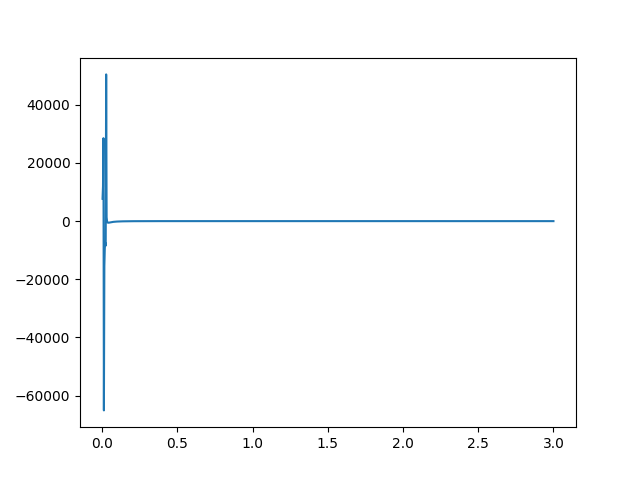

In [3]:
%matplotlib widget
vs = np.linspace(0, 3, 1000)

ps = [system.pressure(z, v, t) for v in vs]

plt.plot(vs, ps)
plt.show()